## Job Generation

In [21]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

## Constant Parameters

In [22]:
# number of jobs
n = 10000
number_of_queues = 4
lmbda = 0.1
mu = 0.2
time_slice = 4.5

In [23]:

jobsArray = []

class Job:
    def __init__(self, arrival_time, service_time, priority):
        self.arrival_time = arrival_time
        self.service_time = service_time
        self.priority = priority
        self.sojourn_time = 0
        self.latency_due_to_preemption = 0
        self.waiting_time = 0
        self.pre_waiting_time = 0
        self.service_start_time = None
        self.service_end_time = None
        self.last_service_time = None
        self.isJobDone = False
        self.service_left = service_time
        self.num_preemptions = 0
        

def generate_exponential_xi(n, lmbda):
    y = np.random.uniform(0, 1, n)
    x = [-np.log(1 - y[i]) / lmbda for i in range(len(y))]
    return x

def generate_si_sigma_xi(n):
    n_sorted = sorted(n)
    si_sigma_xi = []
    for i in range(len(n_sorted)):
        si_sigma_xi.append(sum(n_sorted[:i+1]))
    return si_sigma_xi

def generate_sizes(si_sigma_xi, mu):
    sizes = generate_exponential_xi(len(si_sigma_xi), mu)
    jobs = []
    for i in range(len(si_sigma_xi)):
        jobs.append(Job(si_sigma_xi[i], sizes[i], None))
    return jobs

def assign_priority(jobsArray, number_of_queues, average_service_time):
    bin_size = 2 * average_service_time / number_of_queues
    for job in jobsArray:
        priority = int(job.service_time / bin_size)
        if priority >= number_of_queues:
            priority = number_of_queues - 1
        job.priority = priority
    return jobsArray

def areJobsLeft(jobsArray):
    for job in jobsArray:
        if job.isJobDone == False:   
            return True
    return False

def getHighestPriorityJob(jobsArray,global_clock):
    index = -1
    priority = 100000
    for i, job in enumerate(jobsArray):
        if job.priority <= priority and global_clock >= job.arrival_time and job.isJobDone == False:
            priority = job.priority
            index = i 
            
    return index

def getNextJobArrival(jobsArray):
    index = -1
    for i, job in enumerate(jobsArray):
        if job.isJobDone == False:
            return i 
            
def simulate_queue(jobsArray,numJobs,time_slice):
    global_clock = 0
    numJobsdone = 0
    time_slice = time_slice
    last_job_index = -1
    while numJobsdone != numJobs:
        
        highest_priority_job_index = getHighestPriorityJob(jobsArray,global_clock)
        
        if highest_priority_job_index == -1:
            index =  getNextJobArrival(jobsArray)
            global_clock = jobsArray[index].arrival_time
            highest_priority_job_index = index

        currJob = jobsArray[highest_priority_job_index]  
        if currJob.service_start_time == None:
            jobsArray[highest_priority_job_index].service_start_time = global_clock
            jobsArray[highest_priority_job_index].pre_waiting_time = global_clock - currJob.arrival_time
        else:
            jobsArray[highest_priority_job_index].latency_due_to_preemption += global_clock - jobsArray[highest_priority_job_index].last_service_time
            if last_job_index != highest_priority_job_index:
                jobsArray[highest_priority_job_index].num_preemptions += 1
                
        if currJob.service_left > time_slice:
            global_clock += time_slice
            jobsArray[highest_priority_job_index].service_left -= time_slice
        else:
            global_clock += currJob.service_left
            jobsArray[highest_priority_job_index].isJobDone = True
            jobsArray[highest_priority_job_index].service_left = 0
            jobsArray[highest_priority_job_index].service_end_time = global_clock
            jobsArray[highest_priority_job_index].waiting_time = jobsArray[highest_priority_job_index].pre_waiting_time + jobsArray[highest_priority_job_index].latency_due_to_preemption
            jobsArray[highest_priority_job_index].sojourn_time = jobsArray[highest_priority_job_index].waiting_time + jobsArray[highest_priority_job_index].service_time
            numJobsdone += 1
        
        last_job_index = highest_priority_job_index
        jobsArray[highest_priority_job_index].last_service_time = global_clock


## Queuing parameters

In [24]:

xi = generate_exponential_xi(n, lmbda)
si_sigma_xi = generate_si_sigma_xi(xi)
jobsArray = generate_sizes(si_sigma_xi, mu)
jobsArray = assign_priority(jobsArray, number_of_queues, 1/mu)    
# Count number of jobs in each queue
count = [0] * number_of_queues
for job in jobsArray:
    count[job.priority] += 1
print("Counts per priority:", count)

# Simulate the queue with the given arrival times and sizes using sjf
simulate_queue(jobsArray,n,time_slice)


Counts per priority: [3836, 2407, 1495, 2262]


In [25]:

print("Jobs:")
for job in jobsArray:
    print("Arrival Time:", job.arrival_time, "Service Time:", job.service_time, "Priority:", job.priority, "Waiting Time:", job.pre_waiting_time)


Jobs:
Arrival Time: 0.00021738482074855337 Service Time: 0.18151966116135274 Priority: 0 Waiting Time: 0.0
Arrival Time: 0.0007694505776568423 Service Time: 4.235450576728198 Priority: 1 Waiting Time: 3094.3657785232836
Arrival Time: 0.003968108308638295 Service Time: 2.143684353621345 Priority: 0 Waiting Time: 428.98462384640646
Arrival Time: 0.008031978164661203 Service Time: 0.3336802664056804 Priority: 0 Waiting Time: 428.6468797101448
Arrival Time: 0.01269316358634257 Service Time: 0.03499147217134626 Priority: 0 Waiting Time: 428.60722705255176
Arrival Time: 0.01771083116054693 Service Time: 7.853400401967392 Priority: 3 Waiting Time: 36437.49244045898
Arrival Time: 0.025294617651405234 Service Time: 5.459048082297544 Priority: 2 Waiting Time: 8399.105297951637
Arrival Time: 0.03332456534785786 Service Time: 5.043010139255419 Priority: 2 Waiting Time: 8392.621566042866
Arrival Time: 0.04156697099700537 Service Time: 8.674438515386164 Priority: 3 Waiting Time: 36422.198643643664
A

## Average Service Time for simulation

In [26]:

def getAverageServiceTime(jobsArray):
    totserviceTime = 0
    for job in jobsArray:
        totserviceTime += job.service_time
    avg_time = totserviceTime/len(jobsArray)
    return avg_time    

def getAverageWaitingTime(jobsArray):
    totWaitingTime = 0
    for job in jobsArray:
        totWaitingTime += job.pre_waiting_time+job.latency_due_to_preemption
    avg_time = totWaitingTime/len(jobsArray)
    return avg_time  

def getAverageSojournTime(jobsArray):
    totSojournTime = 0
    for job in jobsArray:
        totSojournTime += job.sojourn_time
    avg_time = totSojournTime/len(jobsArray)
    return avg_time 

print(getAverageServiceTime(jobsArray))
print(getAverageWaitingTime(jobsArray))
print(getAverageSojournTime(jobsArray))


5.027727395584284
2216.9070560199707
2221.934783415567


## Response Time Vs Arrivals

[(0.00021738482074855337, 0.0, 0), (0.0007694505776568423, 3094.3657785232836, 1), (0.003968108308638295, 428.98462384640646, 0), (0.008031978164661203, 428.6468797101448, 0), (0.01269316358634257, 428.60722705255176, 0), (0.01771083116054693, 36437.49244045898, 3), (0.025294617651405234, 8399.105297951637, 2), (0.03332456534785786, 8392.621566042866, 2), (0.04156697099700537, 36422.198643643664, 3), (0.05030123171813297, 428.437535545138, 0), (0.05939954871631016, 36401.69752719348, 3), (0.06982256221699079, 36351.36096940936, 3), (0.0802762243807095, 36286.617947069106, 3), (0.09103744591918558, 426.0551560454592, 0), (0.10343790462424048, 8383.570705788477, 2), (0.1170553690418008, 421.7746408823933, 0), (0.13383990015047362, 419.001338741218, 0), (0.1519509272054563, 3088.3903853527813, 1), (0.17036632955112085, 0.011370716430980421, 0), (0.18930170858968198, 417.45489677576325, 0), (0.20899058454974695, 3081.603419795268, 1), (0.23104816445694448, 416.9415518761728, 0), (0.2532653

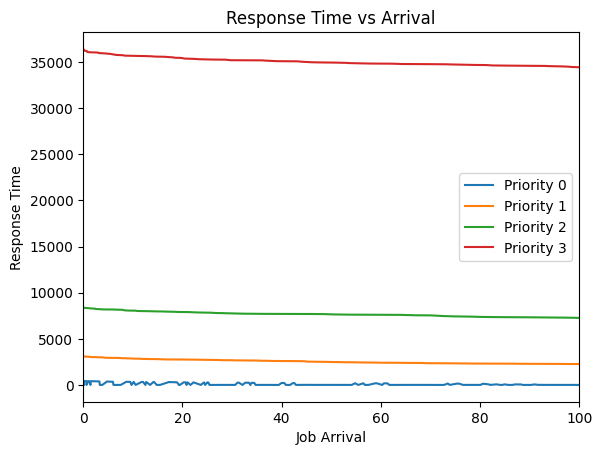

In [27]:
waitingTimesArray = []

for i, job in enumerate(jobsArray):
    waitingTimesArray.append((job.arrival_time,job.pre_waiting_time,job.priority))
    
print(waitingTimesArray)

priority_data = {}
for arrival_time, pre_waiting_time, priority in waitingTimesArray:
    if priority not in priority_data:
        priority_data[priority] = {'arrival_time': [], 'pre_waiting_time': []}
    priority_data[priority]['arrival_time'].append(arrival_time)
    priority_data[priority]['pre_waiting_time'].append(pre_waiting_time)

for priority in range(4):
    if priority in priority_data:
        data = priority_data[priority]
        plt.plot(data['arrival_time'], data['pre_waiting_time'], label=f'Priority {priority}')

plt.xlabel('Job Arrival')
plt.ylabel('Response Time')
# plt.ylim(0, 100)
plt.xlim(0, 100)
plt.title('Response Time vs Arrival')
plt.legend()
plt.show()

## Waiting Times Vs Arrival

[(0.00021738482074855337, 0.0, 0), (0.0007694505776568423, 3094.3657785232836, 1), (0.003968108308638295, 428.98462384640646, 0), (0.008031978164661203, 428.6468797101448, 0), (0.01269316358634257, 428.60722705255176, 0), (0.01771083116054693, 36437.49244045898, 3), (0.025294617651405234, 8399.105297951637, 2), (0.03332456534785786, 8394.054257864685, 2), (0.04156697099700537, 36422.198643643664, 3), (0.05030123171813297, 428.437535545138, 0), (0.05939954871631016, 36408.91303344652, 3), (0.06982256221699079, 36386.84340565226, 3), (0.0802762243807095, 36327.03782297621, 3), (0.09103744591918558, 426.0551560454592, 0), (0.10343790462424048, 8383.570705788477, 2), (0.1170553690418008, 421.7746408823933, 0), (0.13383990015047362, 419.001338741218, 0), (0.1519509272054563, 3088.3903853527813, 1), (0.17036632955112085, 0.011370716430980421, 0), (0.18930170858968198, 417.45489677576325, 0), (0.20899058454974695, 3081.603419795268, 1), (0.23104816445694448, 416.9415518761728, 0), (0.25326535

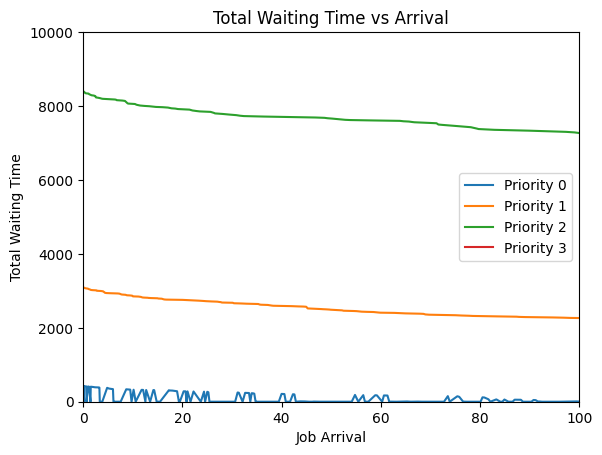

In [28]:
waitingTimesArray = []

for i, job in enumerate(jobsArray):
    waitingTimesArray.append((job.arrival_time,job.pre_waiting_time + job.latency_due_to_preemption ,job.priority))
    
print(waitingTimesArray)

priority_data = {}
for arrival_time, total_waiting_time, priority in waitingTimesArray:
    if priority not in priority_data:
        priority_data[priority] = {'arrival_time': [], 'total_waiting_time': []}
    priority_data[priority]['arrival_time'].append(arrival_time)
    priority_data[priority]['total_waiting_time'].append(total_waiting_time)

for priority in range(4):
    if priority in priority_data:
        data = priority_data[priority]
        plt.plot(data['arrival_time'], data['total_waiting_time'], label=f'Priority {priority}')

plt.xlabel('Job Arrival')
plt.ylabel('Total Waiting Time')
plt.ylim(0, 10000)
plt.xlim(0, 100)
plt.title('Total Waiting Time vs Arrival')
plt.legend()
plt.show()

## Latency Times Vs Arrival

[(0.00021738482074855337, 0, 0), (0.0007694505776568423, 0, 1), (0.003968108308638295, 0, 0), (0.008031978164661203, 0, 0), (0.01269316358634257, 0, 0), (0.01771083116054693, 0.0, 3), (0.025294617651405234, 0.0, 2), (0.03332456534785786, 1.4326918218193896, 2), (0.04156697099700537, 0.0, 3), (0.05030123171813297, 0, 0), (0.05939954871631016, 7.2155062530437135, 3), (0.06982256221699079, 35.482436242898984, 3), (0.0802762243807095, 40.419875907100504, 3), (0.09103744591918558, 0, 0), (0.10343790462424048, 0.0, 2), (0.1170553690418008, 0, 0), (0.13383990015047362, 0, 0), (0.1519509272054563, 0, 1), (0.17036632955112085, 0, 0), (0.18930170858968198, 0, 0), (0.20899058454974695, 0, 1), (0.23104816445694448, 0, 0), (0.25326535356110536, 0.0, 2), (0.27574463217786566, 0, 0), (0.30234112448558365, 5.355494655959774, 3), (0.3291244601696965, 9.42797250143667, 2), (0.35673943973737693, 0, 1), (0.38436004965610265, 0, 0), (0.41446301047266265, 3.9508646157887597, 1), (0.4459060708481629, 0.0, 2)

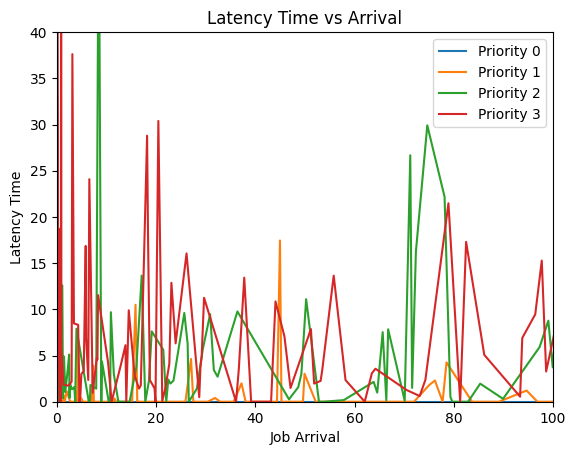

In [29]:
waitingTimesArray = []

for i, job in enumerate(jobsArray):
    waitingTimesArray.append((job.arrival_time,job.latency_due_to_preemption ,job.priority))
    
print(waitingTimesArray)

priority_data = {}
for arrival_time, latency_due_to_preemption, priority in waitingTimesArray:
    if priority not in priority_data:
        priority_data[priority] = {'arrival_time': [], 'latency_due_to_preemption': []}
    priority_data[priority]['arrival_time'].append(arrival_time)
    priority_data[priority]['latency_due_to_preemption'].append(latency_due_to_preemption)

for priority in range(4):
    if priority in priority_data:
        data = priority_data[priority]
        plt.plot(data['arrival_time'], data['latency_due_to_preemption'], label=f'Priority {priority}')



plt.xlabel('Job Arrival')
plt.ylabel('Latency Time')
plt.ylim(0, 40)
plt.xlim(0, 100)
plt.title('Latency Time vs Arrival')
plt.legend()
plt.show()

## Number of Preemptions Vs Priority

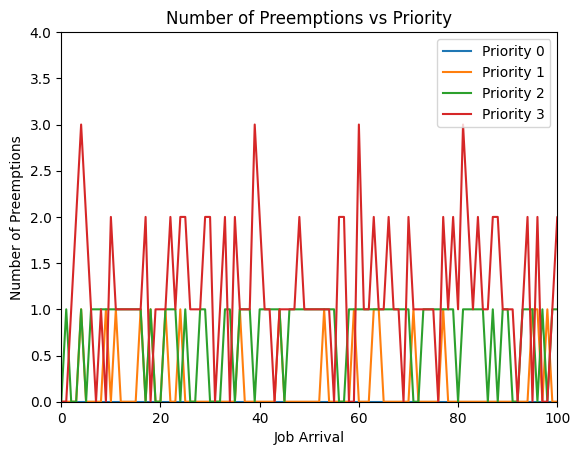

In [30]:
#number of preemptions vs priority

preemptions_data = []

for i, job in enumerate(jobsArray):
    preemptions_data.append((job.num_preemptions,job.priority))

priority_data = {}

for num_preemptions, priority in preemptions_data:
    if priority not in priority_data:
        priority_data[priority] = {'num_preemptions': []}
    priority_data[priority]['num_preemptions'].append(num_preemptions)

for priority in range(4):
    if priority in priority_data:
        data = priority_data[priority]
        plt.plot(data['num_preemptions'], label=f'Priority {priority}')

plt.xlabel('Job Arrival')
plt.ylabel('Number of Preemptions')
plt.ylim(0, 4)
plt.xlim(0, 100)
plt.title('Number of Preemptions vs Priority')
plt.legend()
plt.show()